In [1]:
import open3d as o3d
import pyrealsense2 as rs
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import itertools

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def acquire(n_frames):
    nframes = n_frames

    # Camera RIGHT
    pipeline = rs.pipeline()
    config = rs.config()
    config.enable_device('233722072412')
    pipeline_wrapper = rs.pipeline_wrapper(pipeline)
    pipeline_profile = config.resolve(pipeline_wrapper)
    device = pipeline_profile.get_device()
    advnc_mode = rs.rs400_advanced_mode(device)
    current_std_depth_table = advnc_mode.get_depth_table()
    current_std_depth_table.depthClampMin = 0
    current_std_depth_table.depthClampMax = 800
    advnc_mode.set_depth_table(current_std_depth_table)
    config.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 30)
    config.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)

    # Camera LEFT
    pipeline_2 = rs.pipeline()
    config_2 = rs.config()
    config_2.enable_device('032622070359')
    pipeline_wrapper_2 = rs.pipeline_wrapper(pipeline_2)
    pipeline_profile_2 = config_2.resolve(pipeline_wrapper_2)
    device_2 = pipeline_profile_2.get_device()
    advnc_mode_2 = rs.rs400_advanced_mode(device_2)
    current_std_depth_table_2 = advnc_mode_2.get_depth_table()
    current_std_depth_table_2.depthClampMin = 0
    current_std_depth_table_2.depthClampMax = 800
    advnc_mode_2.set_depth_table(current_std_depth_table_2)
    config_2.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 30)
    config_2.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)


    align = rs.align(rs.stream.depth)
    cfg = pipeline.start(config)
    profile = cfg.get_stream(rs.stream.depth)
    intr_right = profile.as_video_stream_profile().get_intrinsics()

    cfg_2 = pipeline_2.start(config_2)
    profile_2 = cfg_2.get_stream(rs.stream.depth)
    intr_left = profile_2.as_video_stream_profile().get_intrinsics()

    depths_left = []
    depths_right = []
    cnt = 0
    print("Acquisizione iniziata")
    while cnt<=90+nframes:
        # RIGHT
        frames = pipeline.wait_for_frames()
        frames = align.process(frames)
        depth_frame = frames.get_depth_frame()
        depth_image = np.asarray(depth_frame.get_data())
        if cnt>90:
            depths_right.append(depth_image)
        color_frame = frames.get_color_frame()
        color_image = np.asarray(color_frame.get_data())

        #LEFT
        frames_2 = pipeline_2.wait_for_frames()
        frames_2 = align.process(frames_2)
        depth_frame_2 =frames_2.get_depth_frame()
        depth_image_2 = np.asarray(depth_frame_2.get_data())
        if cnt>=90:
            depths_left.append(depth_image_2)
        color_frame_2 = frames_2.get_color_frame()
        color_image_2 = np.asarray(color_frame_2.get_data())

        cnt += 1

    pipeline.stop()
    pipeline_2.stop()
    print("Acquisizione finita")
    variances_left = np.zeros((720, 1280))
    means_left = np.zeros((720, 1280))
    inliers_left = np.zeros((720, 1280))
    variances_right = np.zeros((720, 1280))
    means_right = np.zeros((720, 1280))
    inliers_right = np.zeros((720, 1280))
    for i in range(0, 720):
        for j in range(0, 1280):
            support_left = []
            support_right = []
            for k in range(0, nframes):
                if depths_left[k][i][j] > 0:
                    support_left.append(depths_left[k][i][j])
                if depths_right[k][i][j] > 0:
                    support_right.append(depths_right[k][i][j])
            if len(support_left) > 0:
                inliers_left[i,j] = len(support_left)
                variances_left[i,j] = np.var(support_left)
                means_left [i,j] = np.mean(support_left)
            else:
                variances_left[i,j] = -1
            if len(support_right) > 0:
                inliers_right[i,j] = len(support_right)
                variances_right[i,j] = np.var(support_right)
                means_right [i,j] = np.mean(support_right)
            else:
                variances_right[i,j] = -1
    return depths_left, variances_left, means_left, inliers_left, color_image_2, depths_right, variances_right, means_right, inliers_right, color_image, intr_left, intr_right

In [3]:
# LEFT
def get_maps(variances, means, threshold=None):
    max_value = variances.max()
    invalid_indexes = np.argwhere(variances==-1)
    valid_variances = np.copy(variances)
    valid_variances[invalid_indexes[:,0], invalid_indexes[:,1]] = max_value
    if threshold is None:
        threshold = np.median(variances[variances!=-1])
    print(f'Threshold: {threshold}')

    from scipy.interpolate import interp1d

    img_indexes = np.argwhere(valid_variances<threshold)
    high_variance_indexes = np.argwhere(valid_variances>=threshold)

    
    filtered_means = np.copy(means)
    filtered_means[high_variance_indexes[:,0], high_variance_indexes[:,1]] = 0
    zero_variance_indexes = np.argwhere(valid_variances==0)
    zero_variance_image = np.zeros((720, 1280))
    zero_variance_image[zero_variance_indexes[:,0], zero_variance_indexes[:,1]] = 255

    variance_image = np.zeros((720, 1280))
    m = interp1d([valid_variances.min(),threshold],[0,254])
    variance_image[img_indexes[:,0], img_indexes[:,1]] =  m(valid_variances[img_indexes[:,0], img_indexes[:,1]])

    variance_image[high_variance_indexes[:,0], high_variance_indexes[:,1]] = 255

    return variance_image, zero_variance_image, threshold, filtered_means

In [160]:
d_l, v_l, m_l, in_l, col_l, d_r, v_r, m_r, in_r, col_r, intr_left, intr_right = acquire(90)

Acquisizione iniziata
Acquisizione finita


In [162]:
variance_image_l, zero_variance_image_l, threshold_l, filtered_means_l = get_maps(v_l, m_l, 1)
variance_image_r, zero_variance_image_r, threshold_r, filtered_means_r = get_maps(v_r, m_r, 1)

Threshold: 1
Threshold: 1


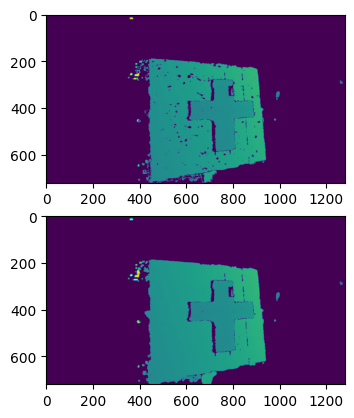

In [163]:
plt.subplot(2,1,1)
plt.imshow(filtered_means_l)
plt.subplot(2,1,2)
plt.imshow(m_l)

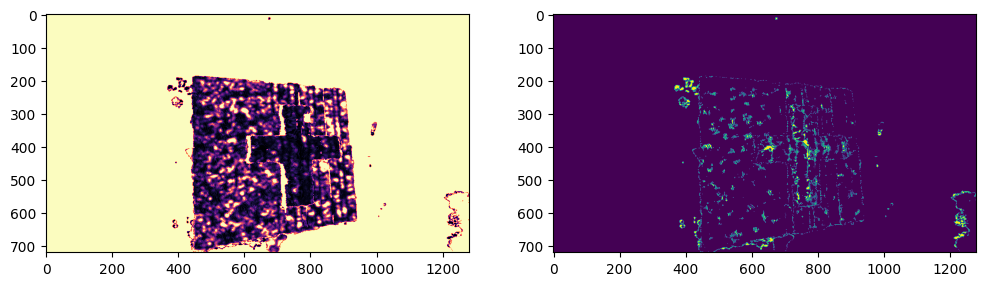

LEFT IMAGE: variance map with max value: 1 mm
RIGHT IMAGE: Zero variance map


In [149]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(variance_image_l, cmap="magma")
cv2.imwrite("varianza zero.png", variance_image_l)
plt.subplot(1,2,2)
plt.imshow(zero_variance_image_l)
plt.show()
print(f'LEFT IMAGE: variance map with max value: {threshold_l} mm\nRIGHT IMAGE: Zero variance map')

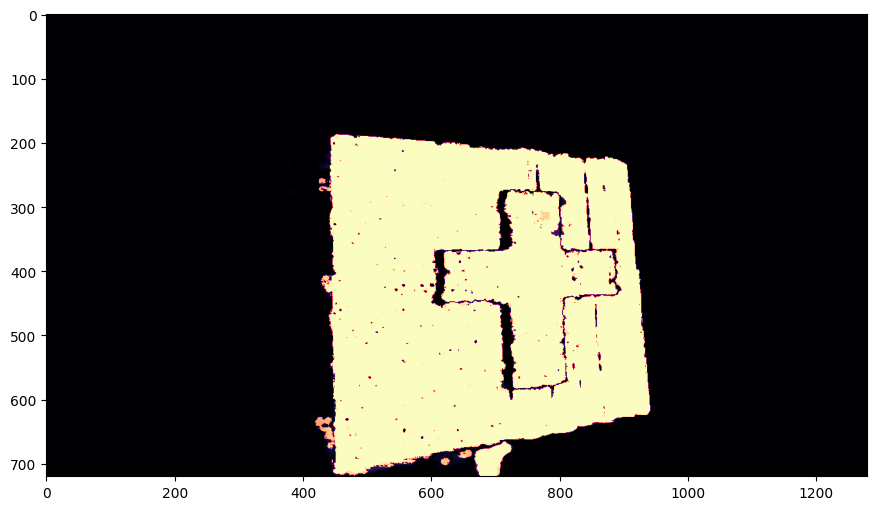

In [108]:
# Inliers map
from scipy.interpolate import interp1d

m = interp1d([in_l.min(),in_l.max()],[0,255])
inliers_map = m(in_l)
plt.figure(figsize=(12,6))
plt.imshow(inliers_map, cmap="magma")

In [109]:
valid = v_l[v_l>-1]
hist_variance, aa = np.histogram(valid[valid < threshold_l], bins=100)

In [91]:
hist_variance, aa

(array([15386,  2572,  6315,  3880,  5382,  4932,  5601,  5437,  5619,
         8515,  4726,  5384,  5845,  7276,  4584,  4488,  6705,  4850,
         3654,  4410,  3321,  3255,  3351,  2624,  3446,  2772,  2283,
         2763,  2024,  2267,  2021,  1825,  2079,  1805,  1635,  1853,
         1943,  1512,  1406,  1396,  1499,  1523,  1391,  1133,  1399,
         1314,   980,  1481,  1100,  1073,  1172,   868,  1080,   927,
          937,   921,  1000,   879,   714,   875,   761,   912,   813,
          566,   987,   549,   656,   631,   599,   683,   490,   696,
          532,   652,   373,   611,   574,   445,   514,   417,   561,
          391,   634,   254,   636,   323,   317,   542,   388,   540,
          234,   503,   215,   543,   199,   340,   362,   289,   399,
          240], dtype=int64),
 array([0.        , 0.00999871, 0.01999742, 0.02999613, 0.03999483,
        0.04999354, 0.05999225, 0.06999096, 0.07998967, 0.08998838,
        0.09998709, 0.1099858 , 0.1199845 , 0.1299832

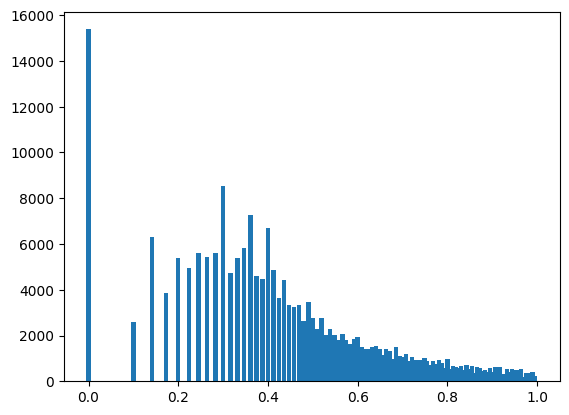

In [92]:
plt.bar(np.sqrt(aa[:-1]), hist_variance, width=threshold_l/100)  # arguments are passed to np.histogram

plt.show()

In [164]:
indexes = np.argwhere(variance_image_l == 255)
selected_m_l = np.copy(m_l)
selected_m_l[indexes[:,0], indexes[:,1]] = 0
cv2.imwrite("leftDepth.png", np.uint16(selected_m_l))
cv2.imwrite("leftColor.jpg", col_l)

indexes = np.argwhere(variance_image_r == 255)
selected_m_r = np.copy(m_r)
selected_m_r[indexes[:,0], indexes[:,1]] = 0
cv2.imwrite("rightDepth.png", np.uint16(selected_m_r))
cv2.imwrite("rightColor.jpg", col_r)


depth_raw_left = o3d.io.read_image("leftDepth.png")
color_raw_left = o3d.io.read_image("leftColor.jpg")
depth_raw_right = o3d.io.read_image("rightDepth.png")
color_raw_right = o3d.io.read_image("rightColor.jpg")
rgbd_image_left = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw_left, depth_raw_left)
rgbd_image_right = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw_right, depth_raw_right)

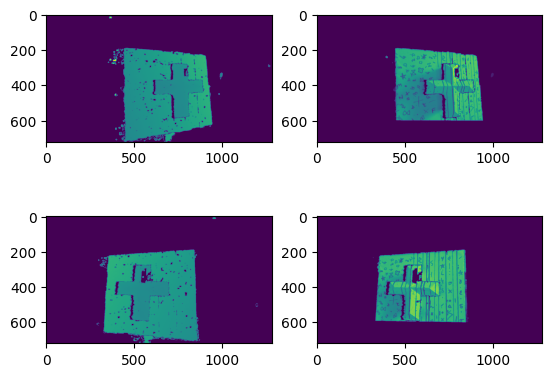

In [165]:
plt.subplot(2,2,1)
plt.imshow(rgbd_image_left.depth)
plt.subplot(2,2,2)
plt.imshow(rgbd_image_left.color)
plt.subplot(2,2,3)
plt.imshow(rgbd_image_right.depth)
plt.subplot(2,2,4)
plt.imshow(rgbd_image_right.color)

In [166]:
import copy

def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    #target_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp],
                                      zoom=0.4459,
                                      front=[1.0, 0.0, 0.0],
                                      lookat=[1, 0, 0],
                                      up=[-0., 1, -0.0])

In [167]:
camera_intrinsic_left = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
    intr_left.width, intr_left.height, intr_left.fx, intr_left.fy, intr_left.ppx, intr_left.ppy
))
camera_intrinsic_right = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
    intr_right.width, intr_right.height, intr_right.fx, intr_right.fy, intr_right.ppx, intr_right.ppy
))

In [168]:
pcd_left = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_left, camera_intrinsic_left)
pcd_right = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_right, camera_intrinsic_right)

bounds = [[-math.inf, math.inf], [-math.inf, math.inf], [0.1, 0.7]]  # set the bounds
bounding_box_points = list(itertools.product(*bounds))  # create limit points
bounding_box = o3d.geometry.AxisAlignedBoundingBox.create_from_points(o3d.utility.Vector3dVector(bounding_box_points))  # create bounding box object

# Crop the point cloud using the bounding box:
pcd_left = pcd_left.crop(bounding_box)
pcd_right = pcd_right.crop(bounding_box)

# Rotazione di 180° intorno all'asse X (ribaltare la point cloud poiché la pinhole camera ribalta la visuale)
angolo = np.pi
trans_x = np.asarray([   [1.0, 0.0, 0.0, 0.0],
                         [0.0, np.cos(angolo), -np.sin(angolo), 0.0],
                         [0.0, np.sin(angolo), np.cos(angolo), 0.0],
                         [0.0, 0.0, 0.0, 1.0]])

pcd_left.transform(trans_x)
pcd_right.transform(trans_x)

# Primario -> Camera di destra 
# Secondario -> Camera di sinistra

# Rotazione di -30° intorno all'asse Y
angolo = np.pi/6
trans_y = np.asarray([[np.cos(angolo), 0.0, np.sin(angolo), -0.34],
                         [0.0, 1.0, 0.0, 0.0],
                         [-np.sin(angolo), 0.0, np.cos(angolo), 0.0],
                         [0.0, 0.0, 0.0, 1.0]])

#pcd_left.transform(trans_y)

#pcd_left.paint_uniform_color((1,0,0))  # LEFT BLU

#pcd_right.paint_uniform_color((0,0,1)) # RIGHT ROSSO

#o3d.visualization.draw_geometries([pcd_left, pcd_right])

In [169]:
angolo = np.pi/6
source = pcd_left
target = pcd_right
threshold = 0.01
trans_init = np.asarray([[np.cos(angolo), 0.0, -np.sin(angolo), -0.31],
                         [0.0, 1.0, 0.0, 0.0],
                         [np.sin(angolo), 0.0, np.cos(angolo), -0.1],
                         [0.0, 0.0, 0.0, 1.0]])
draw_registration_result(source, target, trans_init)

In [170]:
print("Initial alignment")
evaluation = o3d.pipelines.registration.evaluate_registration(
    source, target, threshold, trans_init)
print(evaluation)

Initial alignment
RegistrationResult with fitness=2.198632e-01, inlier_rmse=8.358077e-03, and correspondence_set size of 48030
Access transformation to get result.


In [171]:
print("Apply point-to-point ICP")
reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint(),
    o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=10000))
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)
draw_registration_result(source, target, reg_p2p.transformation)


Apply point-to-point ICP
RegistrationResult with fitness=9.140643e-01, inlier_rmse=1.791997e-03, and correspondence_set size of 199681
Access transformation to get result.
Transformation is:
[[ 8.44403021e-01 -1.00380473e-02 -5.35614391e-01 -3.18472094e-01]
 [ 1.75462649e-02  9.99806223e-01  8.92436242e-03  3.28506437e-04]
 [ 5.35421018e-01 -1.69337906e-02  8.44415526e-01 -9.37992801e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [172]:
calibrated_matrix = reg_p2p.transformation

In [173]:
calibrated_matrix

array([[ 8.44403021e-01, -1.00380473e-02, -5.35614391e-01,
        -3.18472094e-01],
       [ 1.75462649e-02,  9.99806223e-01,  8.92436242e-03,
         3.28506437e-04],
       [ 5.35421018e-01, -1.69337906e-02,  8.44415526e-01,
        -9.37992801e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [119]:
pcd_left = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_left, camera_intrinsic_left)
pcd_right = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_right, camera_intrinsic_right)

bounds = [[-math.inf, math.inf], [-math.inf, 0.15], [0.1, 1.0]]  # set the bounds
bounding_box_points = list(itertools.product(*bounds))  # create limit points
bounding_box = o3d.geometry.AxisAlignedBoundingBox.create_from_points(o3d.utility.Vector3dVector(bounding_box_points))  # create bounding box object

# Crop the point cloud using the bounding box:
pcd_left = pcd_left.crop(bounding_box)
pcd_right = pcd_right.crop(bounding_box)

# Rotazione di 180° intorno all'asse X (ribaltare la point cloud poiché la pinhole camera ribalta la visuale)
angolo = np.pi
trans_x = np.asarray([   [1.0, 0.0, 0.0, 0.0],
                         [0.0, np.cos(angolo), -np.sin(angolo), 0.0],
                         [0.0, np.sin(angolo), np.cos(angolo), 0.0],
                         [0.0, 0.0, 0.0, 1.0]])

pcd_left.transform(trans_x)
pcd_right.transform(trans_x)


pcd_left.transform(calibrated_matrix)

pcd_left.paint_uniform_color((1,0,0))  # LEFT BLU

pcd_right.paint_uniform_color((0,0,1)) # RIGHT ROSSO

o3d.visualization.draw_geometries([pcd_left, pcd_right])

In [79]:
test = pcd_left.transform(reg_p2p.transformation)
p1_load = np.asarray(test.points)
p1_color = np.asarray(test.colors)
p2_load = np.asarray(pcd_right.points)
p2_color = np.asarray(pcd_right.colors)

p3_load = np.concatenate((p1_load, p2_load), axis=0)
p3_color = np.concatenate((p1_color, p2_color), axis=0)

new_pcd = o3d.geometry.PointCloud()
new_pcd.points = o3d.utility.Vector3dVector(p3_load)
new_pcd.colors = o3d.utility.Vector3dVector(p3_color)

In [165]:
o3d.visualization.draw_geometries([new_pcd])

# ACQUISIZIONE

In [178]:
def one_shot():
    # Camera RIGHT
    pipeline = rs.pipeline()
    config = rs.config()
    config.enable_device('233722072412')
    pipeline_wrapper = rs.pipeline_wrapper(pipeline)
    pipeline_profile = config.resolve(pipeline_wrapper)
    device = pipeline_profile.get_device()
    advnc_mode = rs.rs400_advanced_mode(device)
    current_std_depth_table = advnc_mode.get_depth_table()
    current_std_depth_table.depthClampMin = 0
    current_std_depth_table.depthClampMax = 800
    advnc_mode.set_depth_table(current_std_depth_table)
    config.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 30)
    config.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)

    # Camera LEFT
    pipeline_2 = rs.pipeline()
    config_2 = rs.config()
    config_2.enable_device('032622070359')
    pipeline_wrapper_2 = rs.pipeline_wrapper(pipeline_2)
    pipeline_profile_2 = config_2.resolve(pipeline_wrapper_2)
    device_2 = pipeline_profile_2.get_device()
    advnc_mode_2 = rs.rs400_advanced_mode(device_2)
    current_std_depth_table_2 = advnc_mode_2.get_depth_table()
    current_std_depth_table_2.depthClampMin = 0
    current_std_depth_table_2.depthClampMax = 800
    advnc_mode_2.set_depth_table(current_std_depth_table_2)
    config_2.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 30)
    config_2.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)


    align = rs.align(rs.stream.depth)
    cfg = pipeline.start(config)
    profile = cfg.get_stream(rs.stream.depth)
    intr_right = profile.as_video_stream_profile().get_intrinsics()

    cfg_2 = pipeline_2.start(config_2)
    profile_2 = cfg_2.get_stream(rs.stream.depth)
    intr_left = profile_2.as_video_stream_profile().get_intrinsics()

    cnt = 0
    print("Acquisizione iniziata")
    while cnt<=90:
        cnt += 1
        frames = pipeline.wait_for_frames()
        frames = align.process(frames)
        frames_2 = pipeline_2.wait_for_frames()
        frames_2 = align.process(frames_2)
    print("\n\n----  CHEESE :-)  ---- \n\n")
    # RIGHT
    frames = pipeline.wait_for_frames()
    frames = align.process(frames)
    depth_frame = frames.get_depth_frame()
    depth_image = np.asarray(depth_frame.get_data())
    color_frame = frames.get_color_frame()
    color_image = np.asarray(color_frame.get_data())

    #LEFT
    frames_2 = pipeline_2.wait_for_frames()
    frames_2 = align.process(frames_2)
    depth_frame_2 =frames_2.get_depth_frame()
    depth_image_2 = np.asarray(depth_frame_2.get_data())
    color_frame_2 = frames_2.get_color_frame()
    color_image_2 = np.asarray(color_frame_2.get_data())
    pipeline.stop()
    pipeline_2.stop()


    print("Acquisizione finita")
    
    return depth_image_2, color_image_2, intr_left, depth_image, color_image, intr_right

def save_pcl(number, pointcloud1, pointcloud2):
    p1_colors = pointcloud1.colors
    p2_colors = pointcloud2.colors
    p1_load = pointcloud1.points
    p2_load = pointcloud2.points
    p3_colors = np.concatenate((p1_colors, p2_colors), axis=0)
    p3_load = np.concatenate((p1_load, p2_load), axis=0)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(p3_load)
    #pcd.colors = o3d.utility.Vector3dVector(p3_colors)
    o3d.io.write_point_cloud(f'./acquisizioni/noncalibrato/{number}.pcd', pcd, write_ascii=False, compressed=False, print_progress=False)
    return True

Acquisizione iniziata


----  CHEESE :-)  ---- 


Acquisizione finita
pointcloud  1
Acquisizione iniziata


----  CHEESE :-)  ---- 


Acquisizione finita
pointcloud  2
Acquisizione iniziata


----  CHEESE :-)  ---- 


Acquisizione finita
pointcloud  3
Acquisizione iniziata


----  CHEESE :-)  ---- 


Acquisizione finita
pointcloud  4
Acquisizione iniziata


----  CHEESE :-)  ---- 


Acquisizione finita
pointcloud  5
Acquisizione iniziata


----  CHEESE :-)  ---- 


Acquisizione finita
pointcloud  6
Acquisizione iniziata


----  CHEESE :-)  ---- 


Acquisizione finita
pointcloud  7
Acquisizione iniziata


----  CHEESE :-)  ---- 


Acquisizione finita
pointcloud  8
Acquisizione iniziata


----  CHEESE :-)  ---- 


Acquisizione finita
pointcloud  9
Acquisizione iniziata


----  CHEESE :-)  ---- 


Acquisizione finita
pointcloud  10
Acquisizione iniziata


----  CHEESE :-)  ---- 


Acquisizione finita
pointcloud  11
Acquisizione iniziata


----  CHEESE :-)  ---- 


Acquisizione finita
poin

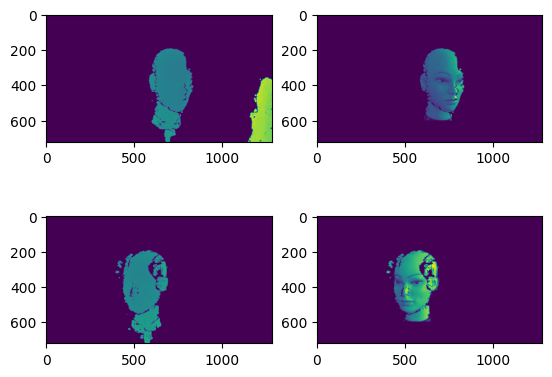

In [177]:
matrice_calibrazione = np.asarray([[ 0.8444589 , -0.01225705, -0.5354801 , -0.31844794],
       [ 0.02003144,  0.99976145,  0.00870546,  0.00107881],
       [ 0.53524566, -0.01807784,  0.84450298, -0.09396772],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

for i in range(1,20):
    depth_image_l, color_image_l, intr_left, depth_image_r, color_image_r, intr_right = one_shot()
    cv2.imwrite("leftDepth.png", depth_image_l)
    cv2.imwrite("leftColor.jpg", color_image_l)

    cv2.imwrite("rightDepth.png", depth_image_r)
    cv2.imwrite("rightColor.jpg", color_image_r)

    depth_raw_left = o3d.io.read_image("leftDepth.png")
    color_raw_left = o3d.io.read_image("leftColor.jpg")
    depth_raw_right = o3d.io.read_image("rightDepth.png")
    color_raw_right = o3d.io.read_image("rightColor.jpg")
    rgbd_image_left = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw_left, depth_raw_left)
    rgbd_image_right = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw_right, depth_raw_right)
    plt.subplot(2,2,1)
    plt.imshow(rgbd_image_left.depth)
    plt.subplot(2,2,2)
    plt.imshow(rgbd_image_left.color)
    plt.subplot(2,2,3)
    plt.imshow(rgbd_image_right.depth)
    plt.subplot(2,2,4)
    plt.imshow(rgbd_image_right.color)

    camera_intrinsic_left = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
        intr_left.width, intr_left.height, intr_left.fx, intr_left.fy, intr_left.ppx, intr_left.ppy
    ))
    camera_intrinsic_right = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
        intr_right.width, intr_right.height, intr_right.fx, intr_right.fy, intr_right.ppx, intr_right.ppy
    ))

    pcd_left = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_left, camera_intrinsic_left)
    pcd_right = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_right, camera_intrinsic_right)

    bounds = [[-math.inf, math.inf], [-math.inf, math.inf], [0.1, 0.7]]  # set the bounds
    bounding_box_points = list(itertools.product(*bounds))  # create limit points
    bounding_box = o3d.geometry.AxisAlignedBoundingBox.create_from_points(o3d.utility.Vector3dVector(bounding_box_points))  # create bounding box object

    # Crop the point cloud using the bounding box:
    pcd_left = pcd_left.crop(bounding_box)
    pcd_right = pcd_right.crop(bounding_box)

    # Rotazione di 180° intorno all'asse X (ribaltare la point cloud poiché la pinhole camera ribalta la visuale)
    angolo = np.pi
    trans_x = np.asarray([   [1.0, 0.0, 0.0, 0.0],
                            [0.0, np.cos(angolo), -np.sin(angolo), 0.0],
                            [0.0, np.sin(angolo), np.cos(angolo), 0.0],
                            [0.0, 0.0, 0.0, 1.0]])

    pcd_left.transform(trans_x)
    pcd_right.transform(trans_x)

    pcd_left.transform(matrice_calibrazione)

    #pcd_left.paint_uniform_color((1,0,0))  # LEFT BLU

    #pcd_right.paint_uniform_color((0,0,1)) # RIGHT ROSSO

    #o3d.visualization.draw_geometries([pcd_left, pcd_right])
    print("pointcloud ",i)
    save_pcl(i, pcd_left, pcd_right)


Acquisizione iniziata


----  CHEESE :-)  ---- 


Acquisizione finita
Apply point-to-point ICP
Transformation 1 is:
[[ 0.99307216 -0.10518637 -0.05237862 -0.12894168]
 [ 0.10494697  0.99445097 -0.00730777 -0.01250373]
 [ 0.05285665  0.00176017  0.99860056 -0.00770196]
 [ 0.          0.          0.          1.        ]]
Acquisizione iniziata


----  CHEESE :-)  ---- 


Acquisizione finita
Apply point-to-point ICP
Transformation 2 is:
[[ 0.9931595  -0.11592749 -0.01396542 -0.11397078]
 [ 0.115814    0.99323298 -0.00868138 -0.01420774]
 [ 0.01487733  0.0070046   0.99986479 -0.00541292]
 [ 0.          0.          0.          1.        ]]
Acquisizione iniziata


----  CHEESE :-)  ---- 


Acquisizione finita
Apply point-to-point ICP
Transformation 3 is:
[[ 0.99200023 -0.09834897 -0.07913926 -0.13959892]
 [ 0.09831417  0.99514594 -0.00434546 -0.01077607]
 [ 0.07918249 -0.00346981  0.9968541  -0.00992571]
 [ 0.          0.          0.          1.        ]]
Acquisizione iniziata


----  CHEESE 

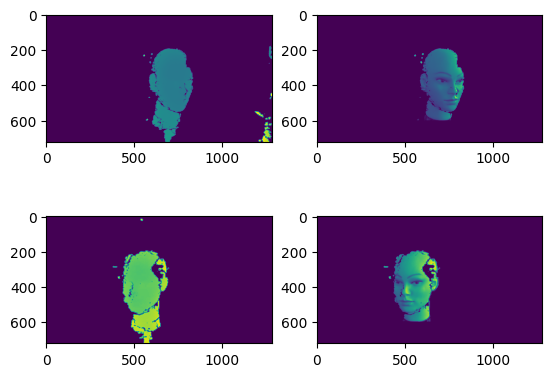

In [179]:
matrice_calibrazione = np.asarray([[ 0.8444589 , -0.01225705, -0.5354801 , -0.31844794],
       [ 0.02003144,  0.99976145,  0.00870546,  0.00107881],
       [ 0.53524566, -0.01807784,  0.84450298, -0.09396772],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

for i in range(1,20):
    depth_image_l, color_image_l, intr_left, depth_image_r, color_image_r, intr_right = one_shot()
    cv2.imwrite("leftDepth.png", depth_image_l)
    cv2.imwrite("leftColor.jpg", color_image_l)

    cv2.imwrite("rightDepth.png", depth_image_r)
    cv2.imwrite("rightColor.jpg", color_image_r)

    depth_raw_left = o3d.io.read_image("leftDepth.png")
    color_raw_left = o3d.io.read_image("leftColor.jpg")
    depth_raw_right = o3d.io.read_image("rightDepth.png")
    color_raw_right = o3d.io.read_image("rightColor.jpg")
    rgbd_image_left = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw_left, depth_raw_left)
    rgbd_image_right = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw_right, depth_raw_right)
    plt.subplot(2,2,1)
    plt.imshow(rgbd_image_left.depth)
    plt.subplot(2,2,2)
    plt.imshow(rgbd_image_left.color)
    plt.subplot(2,2,3)
    plt.imshow(rgbd_image_right.depth)
    plt.subplot(2,2,4)
    plt.imshow(rgbd_image_right.color)

    camera_intrinsic_left = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
        intr_left.width, intr_left.height, intr_left.fx, intr_left.fy, intr_left.ppx, intr_left.ppy
    ))
    camera_intrinsic_right = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
        intr_right.width, intr_right.height, intr_right.fx, intr_right.fy, intr_right.ppx, intr_right.ppy
    ))

    pcd_left = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_left, camera_intrinsic_left)
    pcd_right = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_right, camera_intrinsic_right)

    bounds = [[-math.inf, math.inf], [-math.inf, math.inf], [0.1, 0.7]]  # set the bounds
    bounding_box_points = list(itertools.product(*bounds))  # create limit points
    bounding_box = o3d.geometry.AxisAlignedBoundingBox.create_from_points(o3d.utility.Vector3dVector(bounding_box_points))  # create bounding box object

    # Crop the point cloud using the bounding box:
    pcd_left = pcd_left.crop(bounding_box)
    pcd_right = pcd_right.crop(bounding_box)

    # Rotazione di 180° intorno all'asse X (ribaltare la point cloud poiché la pinhole camera ribalta la visuale)
    angolo = np.pi
    trans_x = np.asarray([   [1.0, 0.0, 0.0, 0.0],
                            [0.0, np.cos(angolo), -np.sin(angolo), 0.0],
                            [0.0, np.sin(angolo), np.cos(angolo), 0.0],
                            [0.0, 0.0, 0.0, 1.0]])

    pcd_left.transform(trans_x)
    pcd_right.transform(trans_x)

    angolo = np.pi/6
    source = pcd_left
    target = pcd_right
    threshold = 0.01
    trans_init = np.asarray([[np.cos(angolo), 0.0, -np.sin(angolo), -0.31],
                            [0.0, 1.0, 0.0, 0.0],
                            [np.sin(angolo), 0.0, np.cos(angolo), -0.1],
                            [0.0, 0.0, 0.0, 1.0]])
    #draw_registration_result(source, target, trans_init)
    
    print("Apply point-to-point ICP")
    reg_p2p = o3d.pipelines.registration.registration_icp(
        source, target, threshold, trans_init,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(),
        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=10000))
    #print(reg_p2p)
    print(f"Transformation {i} is:")
    print(reg_p2p.transformation)
    pcd_left.transform(reg_p2p.transformation)
    save_pcl(i, pcd_left, pcd_right)